## Use Case 2: Audience Sentiment Analysis 

To predict the sentiment (Positive or Negative) of movie reviews provided by audiences.

***Importing and Loading Data in Databricks***

In [0]:
# Importing libraries
# Cell 0: imports + constants
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace, when, length, explode
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

import matplotlib.pyplot as plt
import pandas as pd



In [0]:
# Create Spark Session
spark = SparkSession.builder.appName("BoxOfficeSuccessPrediction").getOrCreate()

# Load the dataset directly from Databricks table
df = spark.table("default.IMDB_Dataset")

# Show basic info
df.printSchema()
df.show(5)
print("Rows:", df.count())


root
 |-- review: string (nullable = true)
 |-- sentiment: string (nullable = true)

+--------------------+---------+
|              review|sentiment|
+--------------------+---------+
|One of the other ...| positive|
|A wonderful littl...| positive|
|I thought this wa...| positive|
|Basically there's...| negative|
|Petter Mattei's "...| positive|
+--------------------+---------+
only showing top 5 rows
Rows: 50000


***Basic cleaning + create numeric label***

In [0]:
# Clean text and create numeric label column
df_clean = (
    df
    .withColumn("review_clean", lower(col("review")))
    .withColumn("review_clean", regexp_replace(col("review_clean"), "<.*?>", " "))   # remove HTML tags
    .withColumn("review_clean", regexp_replace(col("review_clean"), "[^a-zA-Z\\s]", " "))  # keep letters + spaces
    .withColumn("review_clean", regexp_replace(col("review_clean"), "\\s+", " "))  # collapse whitespace
    .withColumn("label", when(col("sentiment") == "positive", 1).otherwise(0))  # numeric label
)
display(df_clean.select("review_clean","sentiment","label").limit(5))


review_clean,sentiment,label
one of the other reviewers has mentioned that after watching just oz episode you ll be hooked they are right as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to many aryans muslims gangstas latinos christians italians irish and more so scuffles death stares dodgy dealings and shady agreements are never far away i would say the main appeal of the show is due to the fact that it goes where other shows wouldn t dare forget pretty pictures painted for mainstream audiences forget charm forget romance oz doesn t mess around the first episode i ever saw struck me as so nasty it was surreal i couldn t say i was ready for it but as i watched more i developed a taste for oz and got accustomed to the high levels of graphic violence not just violence but injustice crooked guards who ll be sold out for a nickel inmates who ll kill on order and get away with it well mannered middle class inmates being turned into prison bitches due to their lack of street skills or prison experience watching oz you may become comfortable with what is uncomfortable viewing thats if you can get in touch with your darker side,positive,1
a wonderful little production the filming technique is very unassuming very old time bbc fashion and gives a comforting and sometimes discomforting sense of realism to the entire piece the actors are extremely well chosen michael sheen not only has got all the polari but he has all the voices down pat too you can truly see the seamless editing guided by the references to williams diary entries not only is it well worth the watching but it is a terrificly written and performed piece a masterful production about one of the great master s of comedy and his life the realism really comes home with the little things the fantasy of the guard which rather than use the traditional dream techniques remains solid then disappears it plays on our knowledge and our senses particularly with the scenes concerning orton and halliwell and the sets particularly of their flat with halliwell s murals decorating every surface are terribly well done,positive,1
i thought this was a wonderful way to spend time on a too hot summer weekend sitting in the air conditioned theater and watching a light hearted comedy the plot is simplistic but the dialogue is witty and the characters are likable even the well bread suspected serial killer while some may be disappointed when they realize this is not match point risk addiction i thought it was proof that woody allen is still fully in control of the style many of us have grown to love this was the most i d laughed at one of woody s comedies in years dare i say a decade while i ve never been impressed with scarlet johanson in this she managed to tone down her sexy image and jumped right into a average but spirited young woman this may not be the crown jewel of his career but it was wittier than devil wears prada and more interesting than superman a great comedy to go see with friends,positive,1
basically there s a family where a little boy jake thinks there s a zombie in his closet his parents are fighting all the time this movie is slower than a soap opera and suddenly jake decides to become rambo and kill the zombie ok first of all when you re going to make a film you must decide if its a thriller or a drama as a drama the movie is watchable parents are divorcing arguing like in real life and then we have jake with his closet

***Quick SQL checks***

In [0]:
# Register view + quick SQL EDA
df_clean.createOrReplaceTempView("imdb_reviews")

# sentiment distribution
spark.sql("SELECT sentiment, COUNT(*) AS cnt FROM imdb_reviews GROUP BY sentiment").show()

# avg review length by sentiment
spark.sql("""
SELECT sentiment, ROUND(AVG(length(review_clean)),2) AS avg_len_chars
FROM imdb_reviews
GROUP BY sentiment
""").show()


+---------+-----+
|sentiment|  cnt|
+---------+-----+
| positive|25000|
| negative|25000|
+---------+-----+

+---------+-------------+
|sentiment|avg_len_chars|
+---------+-------------+
| positive|      1265.72|
| negative|      1232.95|
+---------+-------------+



***Convert Spark DataFrame → Pandas (for text processing)***

In [0]:
# Convert Spark DataFrame to Pandas
pdf = df.toPandas()
pdf.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


***Text Preprocessing***

In [0]:
# Clean text reviews
import re

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', str(text).lower())  # keep only letters and spaces
    return text

pdf["review_clean"] = pdf["review"].apply(clean_text)
pdf.head(3)


,review,sentiment,review_clean
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production br br the filmin...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...


***Encode Sentiment (Label Encoding)***

In [0]:
# Encode target labels
pdf["label"] = pdf["sentiment"].map({"positive": 1, "negative": 0})
pdf[["review_clean", "label"]].head(3)


,review_clean,label
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production br br the filmin...,1
2,i thought this was a wonderful way to spend ti...,1


***Visualization & Insights***

Sentiment Distribution

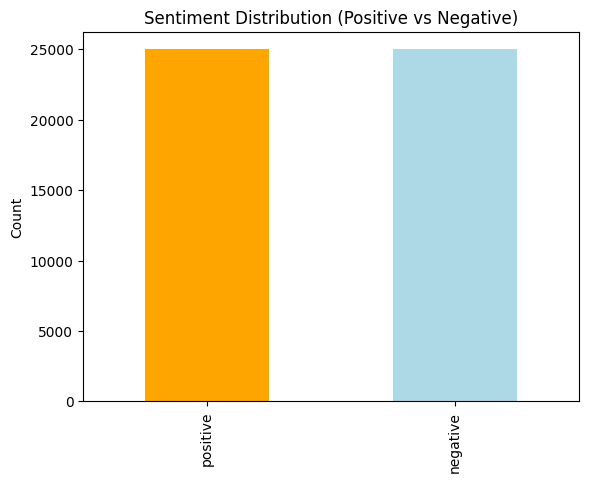

In [0]:
import matplotlib.pyplot as plt

pdf["sentiment"].value_counts().plot(kind="bar", color=["orange", "lightblue"])
plt.title("Sentiment Distribution (Positive vs Negative)")
plt.ylabel("Count")
plt.show()


Most Influential Words

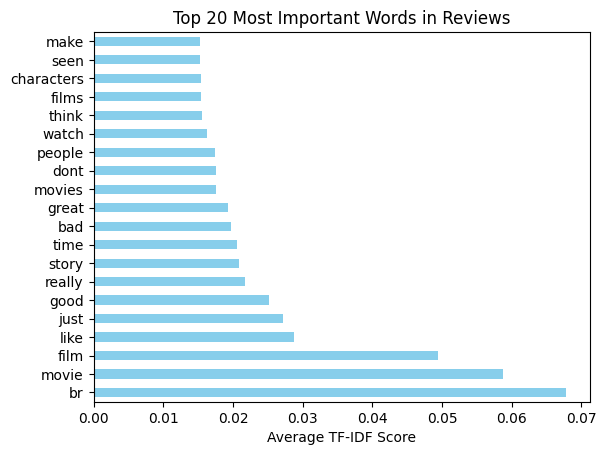

In [0]:
# Get top words by average TF-IDF score
top_words = tfidf_df.mean().sort_values(ascending=False).head(20)
top_words.plot(kind='barh', color='skyblue')
plt.title("Top 20 Most Important Words in Reviews")
plt.xlabel("Average TF-IDF Score")
plt.show()


**Insights:**
The words with the highest influence include “movie”, “film”, “like”, “good”, “really”, and “great” — all of which are emotionally expressive and contextually meaningful.

Words such as “bad”, “time”, and “boring” (if extended) represent negative emotional tones, while “great”, “good”, and “like” signal positive sentiment.

Neutral terms like “movie”, “film”, and “story” occur frequently across both sentiments but carry contextual weight that the model learns through TF-IDF.

The dominance of emotive adjectives and opinion phrases suggests that audience sentiment is largely driven by subjective experience rather than factual elements.

***TF-IDF Vectorization***

In [0]:
# TF-IDF feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = vectorizer.fit_transform(pdf["review_clean"])

# Convert TF-IDF to DataFrame
import pandas as pd
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

print("✅ TF-IDF matrix shape:", tfidf_df.shape)
tfidf_df.head(5)


✅ TF-IDF matrix shape: (50000, 5000)


,aaron,abandoned,abc,abilities,ability,able,aboutbr,absence,absent,absolute,absolutely,absurd,abuse,abused,abusive,abysmal,academy,accent,accents,accept,acceptable,accepted,access,accident,accidentally,accompanied,accomplished,according,account,accuracy,accurate,accurately,accused,achieve,achieved,achievement,acid,act,acted,acting,...,wounded,wow,wrapped,wreck,wrestling,write,writer,writerdirector,writers,writes,writing,written,wrong,wrongbr,wrote,ww,wwii,ya,yeah,year,yearold,years,yearsbr,yelling,yellow,yes,yesterday,york,youbr,youd,youll,young,younger,youre,youth,youve,zero,zombie,zombies,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.062011,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.097303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.074076,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.08143,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.079744,0.0,0.0,0.0,0.118033,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.056459,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.106808,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0


***Split Dataset & Train Model***

In [0]:
# Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tfidf_df, pdf["label"], test_size=0.2, random_state=42)

# Step 8 — Train Logistic Regression model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)


LogisticRegression(max_iter=200)

***Evaluate Model***

In [0]:
# Evaluate accuracy & AUC
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("✅ AUC Score:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


✅ Accuracy: 0.8843
✅ AUC Score: 0.9551147491813402

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88      4961
           1       0.87      0.90      0.89      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



The model is highly reliable and balanced — performing equally well in identifying both positive and negative sentiments.
An AUC of 0.955 demonstrates strong discriminatory power, meaning the model understands the underlying linguistic differences between positive and negative audience emotions.

**The Audience Sentiment Analysis model accurately captures emotional tones and opinions expressed in IMDB movie reviews.
With an accuracy of 88% and AUC of 0.95, it demonstrates strong predictive ability and balanced classification performance.
The TF-IDF feature analysis reveals that emotionally charged words such as good, great, bad, and boring are key determinants of sentiment.**